In [2]:

from iminuit import Minuit
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import jaxopt

import pandas as pd
import numpy as np
from lib.simdata_i3 import I3SimHandlerFtr
from lib.geo import center_track_pos_and_time_based_on_data
from lib.network import get_network_eval_v_fn
from lib.experimental_methods import remove_early_pulses
from dom_track_eval import get_eval_network_doms_and_track
from likelihood_spe import get_neg_c_triple_gamma_llh

# Event Index.
event_index = 3

# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("shifted seed vertex:", centered_track_pos)

muon energy: 2.2 TeV
n_doms 58
original seed vertex: [ 1180.18566012 -1499.16735802  -782.32800156]
shifted seed vertex: [-38.65768538 207.2454018  145.80801123]


In [3]:
# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time']].to_numpy())

# Clean random early events
fitting_event_data = fitting_event_data = remove_early_pulses(eval_network_doms_and_track, 
                                                              fitting_event_data, 
                                                              centered_track_pos, 
                                                              track_src, 
                                                              centered_track_time)

# Setup likelihood
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)

In [5]:
scale = 20.0
@jax.jit
def neg_llh_5D(x):
        zenith = x[0] / scale
        azimuth = x[1] / scale
        zenith = jnp.fmod(zenith, 2.0*jnp.pi)
        zenith = jnp.where(zenith < 0, zenith+2.0*jnp.pi, zenith)
        cond = zenith > jnp.pi
        zenith = jnp.where(cond, -1.0*zenith+2.0*jnp.pi, zenith)
        azimuth = jnp.where(cond, azimuth-jnp.pi, azimuth)

        azimuth = jnp.fmod(azimuth, 2.0*jnp.pi)
        azimuth = jnp.where(azimuth < 0, azimuth+2.0*jnp.pi, azimuth)
        
        projected_dir = jnp.array([zenith, azimuth])
        return neg_llh(projected_dir, x[2:]*scale, centered_track_time, fitting_event_data)

G_poisson_logL = jax.grad(neg_llh_5D)
H_poisson_logL = jax.jacfwd(G_poisson_logL)

In [8]:
x0 = jnp.concatenate([track_src*scale, centered_track_pos/scale])
print(jnp.squeeze(H_poisson_logL(x0)))

[[1034.54889415   41.49182208  205.93611881 -503.65344859  837.31576855]
 [  41.49182208  207.94018926  160.29132379  -60.17490748   64.36933741]
 [ 205.93611881  160.29132379  296.16994143 -133.45839129  282.13215335]
 [-503.65344859  -60.17490748 -133.45839129 2731.74672407  362.78150213]
 [ 837.31576855   64.36933741  282.13215335  362.78150213 1622.60193159]]


In [25]:
@jax.jit
def update(β):
    H, G = jnp.squeeze(H_poisson_logL(β)), G_poisson_logL(β)
    β_new = β - (jnp.dot(jnp.linalg.inv(H), G))
    error = jnp.abs(β_new - β)
    β = β_new
    return β

In [35]:
def newton_raphson(β, tol=1e-3, max_iter=100, display=True):

    i = 0
    error = 100  # Initial error value
  
    while jnp.any(error > tol) and i < max_iter:
        #H, G = jnp.squeeze(H_poisson_logL(β)), G_poisson_logL(β)
        H, G = H_poisson_logL(β), G_poisson_logL(β)
        β_new = β - (jnp.dot(jnp.linalg.inv(H), G))
        error = jnp.abs(β_new - β)
        β = β_new
        #β = update(β)

        i += 1

    return β

In [36]:
best_x = newton_raphson(x0, display=False)
best_logl = neg_llh_5D(result)

print("... solution found.")
print(f"-2*logl={best_logl:.3f}")
print(f"zenith={best_x[0]/scale:.3f}rad")
print(f"azimuth={best_x[1]/scale:.3f}rad")
print(f"x={best_x[2]*scale:.3f}m")
print(f"y={best_x[3]*scale:.3f}m")
print(f"z={best_x[4]*scale:.3f}m")
print(f"at fix time t={centered_track_time:.3f}ns")

... solution found.
-2*logl=737.833
zenith=1.990rad
azimuth=5.346rad
x=-38.956m
y=209.021m
z=145.781m
at fix time t=12375.863ns


In [37]:
%timeit newton_raphson(x0, display=False)

88.1 ms ± 140 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
scale = 20.0
@jax.jit
def neg_llh_3D(x, track_dir):
    return neg_llh(track_dir, x*scale, centered_track_time, fitting_event_data)

In [47]:
G_poisson_logL = jax.grad(neg_llh_3D)
H_poisson_logL = jax.jacfwd(G_poisson_logL)

In [48]:
def newton_raphson(β, track_dir, tol=1e-3, max_iter=100, display=True):

    i = 0
    error = 100  # Initial error value
  
    while jnp.any(error > tol) and i < max_iter:
        #H, G = jnp.squeeze(H_poisson_logL(β)), G_poisson_logL(β)
        H, G = H_poisson_logL(β, track_dir), G_poisson_logL(β, track_dir)
        β_new = β - (jnp.dot(jnp.linalg.inv(H), G))
        error = jnp.abs(β_new - β)
        β = β_new
        #β = update(β)

        i += 1

    return β

In [50]:
import time

time1 = time.time()
# Number of scan points on 1D
n_eval = 20 # making it a 30x30 grid

# Scan range (truth +/- dzen, +/- dazi)
dzen = 0.03 # rad
dazi = 0.03 # rad

zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])

logls = np.zeros(len(init_dirs))

x0 = centered_track_pos/scale
for i, tdir in enumerate(init_dirs):
        result = newton_raphson(x0, tdir)
        #result = solve(x0, tdir, centered_track_time, fitting_event_data)
        logls[i] = neg_llh_3D(result, tdir)

logls = logls.reshape(X.shape)
time2 = time.time()

print(f"elapsed: {time2-time1}s")

elapsed: 112.38145470619202s


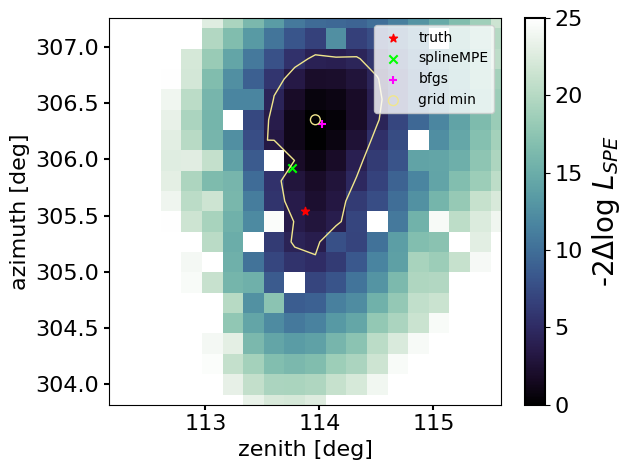

In [53]:
import matplotlib.pyplot as plt
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=False, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

logls[np.isnan(logls)]=999999999999.0
fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([25, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{SPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

zenith = best_x[0]
azimuth = best_x[1]
ax.scatter(np.rad2deg(zenith/scale), np.rad2deg(azimuth/scale), marker='+', color='magenta', label='bfgs')

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()
plt.show()

In [52]:
print(logls)

[[784.01616458 776.19874316 775.05643059 772.25877551 770.10856197
  766.65778236 763.63366248 761.38568679 760.19910231 759.93230283
  760.52511018          nan 762.87722409 764.45275546 766.29135216
  769.42081635 771.97008239 773.28113275 774.22368405 775.4771151 ]
 [775.10335845          nan 910.11845013 771.06024857 768.21577442
  764.40687629 761.10420486 758.78225347 757.38450904 757.25370959
  757.53342103 758.95816731 760.0882718  761.90269389 764.19976454
  766.25420307 768.70400837 785.00651638 773.26300542 773.77429104]
 [787.80491715 776.1806336  771.38838699 769.69607062 767.63281395
  762.60463791 758.94650099 756.82272076 754.69282896 754.0787377
  754.63347065 756.50632701 757.37672    759.52386815 762.45536614
  764.12136578 766.74860799 769.0115252  770.12357608 774.44429836]
 [774.00460086 773.21258106 777.56676069 772.27324655 765.50126289
  762.1442858  760.95245433 754.11171485 752.23192927 751.51786484
  751.89333348 753.82009485 755.27842139 758.3534804  760.30